---
## Sección 1. Configuración inicial

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt

import mlflow
import dagshub
import time

print(f"TensorFlow: {tf.__version__}")
print(f"MLflow: {mlflow.__version__}")

TensorFlow: 2.20.0
MLflow: 3.6.0


In [34]:
# Configurar DagsHub
dagshub.init(repo_owner='404brainnotfound-ai', repo_name='RNA', mlflow=True)

print(f"Tracking URI: {mlflow.get_tracking_uri()}")

Initialized MLflow to track repo "404brainnotfound-ai/RNA"

Repository 404brainnotfound-ai/RNA initialized!

Tracking URI: https://dagshub.com/404brainnotfound-ai/RNA.mlflow


In [35]:
# Verificar disponibilidad de GPU y listar dispositivos físicos
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs disponibles: {len(gpus)}")

if gpus:
    for i, gpu in enumerate(gpus):
        print(f"  GPU {i}: {gpu}")
    
    # Configurar crecimiento de memoria (evita que TensorFlow reserve toda la VRAM)
    tf.config.experimental.set_memory_growth(gpu, True)
    
    # Información adicional sobre la GPU
    print("\nDetalles de GPU:")
    from tensorflow.python.client import device_lib
    local_devices = device_lib.list_local_devices()
    for device in local_devices:
        if device.device_type == 'GPU':
            print(f"  Nombre: {device.physical_device_desc}")
else:
    print("No se detectó ninguna GPU. El entrenamiento usará CPU.")

GPUs disponibles: 1
  GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

Detalles de GPU:
  Nombre: device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


I0000 00:00:1763957663.979528   27461 gpu_device.cc:2020] Created device /device:GPU:0 with 2857 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


In [36]:
# Cargamos lso datos

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Aplanar y normalizar
x_train = x_train.reshape(60000, 784).astype('float32') / 255.0
x_test = x_test.reshape(10000, 784).astype('float32') / 255.0

# Onehot encoding
num_classes = 10
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

In [37]:
def train_and_log(model, run_name, params, epochs=15, batch_size=10):
    """Entrena un modelo y registra en MLflow."""
    
    with mlflow.start_run(run_name=run_name):
        # Registrar parámetros
        mlflow.log_params(params)
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("batch_size", batch_size)
        
        # Entrenar
        start_time = time.time()
        history = model.fit(
            x_train, y_train_cat,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_test, y_test_cat)
        )
        training_time = time.time() - start_time
        
        # Registrar métricas finales
        mlflow.log_metric("training_time", training_time)
        mlflow.log_metric("train_accuracy", history.history['accuracy'][-1])
        mlflow.log_metric("val_accuracy", history.history['val_accuracy'][-1])
        mlflow.log_metric("train_loss", history.history['loss'][-1])
        mlflow.log_metric("val_loss", history.history['val_loss'][-1])
        
        # Resumen
        print(f"\n{run_name}: Val Acc = {history.history['val_accuracy'][-1]:.4f} | Tiempo = {training_time:.2f}s\n")
        
        return history

---
# Sección 2: Experimentos sin regularización

## Experimento 1: Más neuronas en capa oculta

**Hipótesis**: Si aumentamos de 30 a 128 neuronas mejorará la capacidad de aprendizaje.

In [38]:
# Arquitectura: [784, 128, 10]

model_exp1 = Sequential([
    Dense(128, activation='sigmoid', input_shape=(784,)),
    Dense(10, activation='sigmoid')])

model_exp1.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy'])

params_exp1 = {
    'arquitectura': '[784, 128, 10]',
    'activacion': 'sigmoid',
    'optimizer': 'Adam',
    'learning_rate': 0.001,
    'loss': 'binary_crossentropy'}

history_exp1 = train_and_log(model_exp1, "exp1_mas_neuronas", params_exp1)

/home/enriq/tf-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.9051 - loss: 0.0665 - val_accuracy: 0.9469 - val_loss: 0.0366
Epoch 2/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.9537 - loss: 0.0315 - val_accuracy: 0.9597 - val_loss: 0.0269
Epoch 3/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.9672 - loss: 0.0232 - val_accuracy: 0.9682 - val_loss: 0.0221
Epoch 4/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.9750 - loss: 0.0184 - val_accuracy: 0.9711 - val_loss: 0.0197
Epoch 5/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.9804 - loss: 0.0152 - val_accuracy: 0.9734 - val_loss: 0.0187
Epoch 6/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.9839 - loss: 0.0127 - val_accuracy: 0.9740 - val_loss: 0.0171
Epoch 7/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.9865 - loss: 0.0109 - val_accuracy: 0.9749 - val_loss: 0.0164
Epoch 8/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.9894 - loss: 0

## Experimento 2:  Red más profunda

**Hipótesis**: Si agregamos más capas podrá aprender características más complejas

In [39]:
# Arquitectura: [784, 128, 64, 10]
model_exp2 = Sequential([
    Dense(128, activation='sigmoid', input_shape=(784,)),
    Dense(64, activation='sigmoid'),
    Dense(10, activation='sigmoid')])

model_exp2.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy'])

params_exp2 = {
    'arquitectura': '[784, 128, 64, 10]',
    'activacion': 'sigmoid',
    'optimizer': 'Adam',
    'learning_rate': 0.001,
    'loss': 'binary_crossentropy'}

history_exp2 = train_and_log(model_exp2, "exp2_mas_capas", params_exp2)

Epoch 1/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.8896 - loss: 0.0728 - val_accuracy: 0.9476 - val_loss: 0.0318
Epoch 2/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.9590 - loss: 0.0260 - val_accuracy: 0.9637 - val_loss: 0.0217
Epoch 3/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.9727 - loss: 0.0178 - val_accuracy: 0.9726 - val_loss: 0.0170
Epoch 4/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9799 - loss: 0.0134 - val_accuracy: 0.9748 - val_loss: 0.0161
Epoch 5/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - accuracy: 0.9851 - loss: 0.0104 - val_accuracy: 0.9772 - val_loss: 0.0145
Epoch 6/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9887 - loss: 0.0082 - val_accuracy: 0.9773 - val_loss: 0.0151
Epoch 7/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.9911 - loss: 0.0065 - val_accuracy: 0.9804 - val_loss: 0.0137
Epoch 8/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.9937 - loss: 0

## Experimento 3: ReLU y Softmax

**Hipótesis**: ReLU en capas ocultas y softmax en salida son más adecuados para clasificación.

In [40]:
# Arquitectura: [784, 128, 64, 10] con ReLU y softmax
model_exp3 = Sequential([
    Dense(128, activation='relu', input_shape=(784,)),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')])

model_exp3.compile(
    loss='categorical_crossentropy',  # Cambio a categorical por softmax
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy'])

params_exp3 = {
    'arquitectura': '[784, 128, 64, 10]',
    'activacion': 'relu + softmax',
    'optimizer': 'Adam',
    'learning_rate': 0.001,
    'loss': 'categorical_crossentropy'}

history_exp3 = train_and_log(model_exp3, "exp3_relu_softmax", params_exp3)

Epoch 1/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.9373 - loss: 0.2094 - val_accuracy: 0.9658 - val_loss: 0.1100
Epoch 2/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9704 - loss: 0.0968 - val_accuracy: 0.9722 - val_loss: 0.0887
Epoch 3/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - accuracy: 0.9790 - loss: 0.0686 - val_accuracy: 0.9767 - val_loss: 0.0795
Epoch 4/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - accuracy: 0.9831 - loss: 0.0559 - val_accuracy: 0.9746 - val_loss: 0.0890
Epoch 5/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.9862 - loss: 0.0443 - val_accuracy: 0.9789 - val_loss: 0.0836
Epoch 6/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - accuracy: 0.9878 - loss: 0.0384 - val_accuracy: 0.9776 - val_loss: 0.0945
Epoch 7/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.9896 - loss: 0.0337 - val_accuracy: 0.9793 - val_loss: 0.0871
Epoch 8/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.9904 - loss: 0

## Comparación de experimentos sin regularización

In [49]:
# Comparar resultados

print(f"Exp 1 (más neuronas):   Val Acc = {history_exp1.history['val_accuracy'][-1]:.10f}")
print(f"Exp 2 (más capas):      Val Acc = {history_exp2.history['val_accuracy'][-1]:.10f}")
print(f"Exp 3 (ReLU+softmax):   Val Acc = {history_exp3.history['val_accuracy'][-1]:.10f}")

# Identificar el mejor
best_acc = max(
    history_exp1.history['val_accuracy'][-1],
    history_exp2.history['val_accuracy'][-1],
    history_exp3.history['val_accuracy'][-1])

print(f"El mejor Val Accuracy es: {best_acc:.10f}")

Exp 1 (más neuronas):   Val Acc = 0.9786000252
Exp 2 (más capas):      Val Acc = 0.9797999859
Exp 3 (ReLU+softmax):   Val Acc = 0.9787999988
El mejor Val Accuracy es: 0.9797999859


---
# SECCIÓN 3: Experimentos con regularización

Usaremos la mejor arquitectura del experimento anterior y probaremos diferentes regularizaciones.

## Experimento 4: Regularización L1

In [50]:
model_exp4 = Sequential([
    Dense(128, activation='relu', input_shape=(784,),
          kernel_regularizer=regularizers.l1(0.001)),
    Dense(64, activation='relu',
          kernel_regularizer=regularizers.l1(0.001)),
    Dense(10, activation='softmax')])

model_exp4.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy'])

params_exp4 = {
    'arquitectura': '[784, 128, 64, 10]',
    'activacion': 'relu + softmax',
    'optimizer': 'Adam',
    'learning_rate': 0.001,
    'loss': 'categorical_crossentropy',
    'regularizacion': 'L1',
    'l1_factor': 0.001}

history_exp4 = train_and_log(model_exp4, "exp4_L1", params_exp4)

/home/enriq/tf-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.8957 - loss: 0.9242 - val_accuracy: 0.9340 - val_loss: 0.5605
Epoch 2/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.9314 - loss: 0.5287 - val_accuracy: 0.9407 - val_loss: 0.4718
Epoch 3/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.9363 - loss: 0.4814 - val_accuracy: 0.9390 - val_loss: 0.4539
Epoch 4/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.9402 - loss: 0.4580 - val_accuracy: 0.9469 - val_loss: 0.4346
Epoch 5/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.9413 - loss: 0.4457 - val_accuracy: 0.9478 - val_loss: 0.4167
Epoch 6/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.9417 - loss: 0.4381 - val_accuracy: 0.9480 - val_loss: 0.4171
Epoch 7/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.9431 - loss: 0.4316 - val_accuracy: 0.9492 - val_loss: 0.4039
Epoch 8/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.9430 - loss: 0

## Experimento 5: Regularización L2

In [51]:
model_exp5 = Sequential([
    Dense(128, activation='relu', input_shape=(784,),
          kernel_regularizer=regularizers.l2(0.001)),
    Dense(64, activation='relu',
          kernel_regularizer=regularizers.l2(0.001)),
    Dense(10, activation='softmax')])

model_exp5.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy'])

params_exp5 = {
    'arquitectura': '[784, 128, 64, 10]',
    'activacion': 'relu + softmax',
    'optimizer': 'Adam',
    'learning_rate': 0.001,
    'loss': 'categorical_crossentropy',
    'regularizacion': 'L2',
    'l2_factor': 0.001}

history_exp5 = train_and_log(model_exp5, "exp5_L2", params_exp5)

Epoch 1/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - accuracy: 0.9295 - loss: 0.3939 - val_accuracy: 0.9530 - val_loss: 0.2919
Epoch 2/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.9568 - loss: 0.2657 - val_accuracy: 0.9412 - val_loss: 0.3022
Epoch 3/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.9615 - loss: 0.2348 - val_accuracy: 0.9558 - val_loss: 0.2423
Epoch 4/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.9641 - loss: 0.2210 - val_accuracy: 0.9633 - val_loss: 0.2097
Epoch 5/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.9646 - loss: 0.2095 - val_accuracy: 0.9671 - val_loss: 0.2060
Epoch 6/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.9667 - loss: 0.2032 - val_accuracy: 0.9672 - val_loss: 0.1906
Epoch 7/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.9656 - loss: 0.1997 - val_accuracy: 0.9677 - val_loss: 0.1978
Epoch 8/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.9664 - loss: 0

## Experimento 6: Regularización L1-L2

In [52]:
model_exp6 = Sequential([
    Dense(128, activation='relu', input_shape=(784,),
          kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)),
    Dense(64, activation='relu',
          kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)),
    Dense(10, activation='softmax')])

model_exp6.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy'])

params_exp6 = {
    'arquitectura': '[784, 128, 64, 10]',
    'activacion': 'relu + softmax',
    'optimizer': 'Adam',
    'learning_rate': 0.001,
    'loss': 'categorical_crossentropy',
    'regularizacion': 'L1-L2',
    'l1_factor': 0.001,
    'l2_factor': 0.001}

history_exp6 = train_and_log(model_exp6, "exp6_L1_L2", params_exp6)

Epoch 1/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.8924 - loss: 0.9275 - val_accuracy: 0.9228 - val_loss: 0.5816
Epoch 2/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.9233 - loss: 0.5599 - val_accuracy: 0.9264 - val_loss: 0.5118
Epoch 3/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.9315 - loss: 0.5025 - val_accuracy: 0.9364 - val_loss: 0.4727
Epoch 4/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.9338 - loss: 0.4828 - val_accuracy: 0.9305 - val_loss: 0.5026
Epoch 5/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.9361 - loss: 0.4678 - val_accuracy: 0.9436 - val_loss: 0.4430
Epoch 6/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - accuracy: 0.9371 - loss: 0.4529 - val_accuracy: 0.9349 - val_loss: 0.4547
Epoch 7/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.9399 - loss: 0.4424 - val_accuracy: 0.9364 - val_loss: 0.4457
Epoch 8/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - accuracy: 0.9396 - loss: 0

## Experimento 7: Dropout

In [53]:
model_exp7 = Sequential([
    Dense(128, activation='relu', input_shape=(784,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')])

model_exp7.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy'])

params_exp7 = {
    'arquitectura': '[784, 128, 64, 10]',
    'activacion': 'relu + softmax',
    'optimizer': 'Adam',
    'learning_rate': 0.001,
    'loss': 'categorical_crossentropy',
    'regularizacion': 'Dropout',
    'dropout_rate': 0.3}

history_exp7 = train_and_log(model_exp7, "exp7_Dropout", params_exp7)

Epoch 1/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.8982 - loss: 0.3413 - val_accuracy: 0.9619 - val_loss: 0.1278
Epoch 2/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.9430 - loss: 0.1931 - val_accuracy: 0.9673 - val_loss: 0.1095
Epoch 3/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.9523 - loss: 0.1611 - val_accuracy: 0.9676 - val_loss: 0.1088
Epoch 4/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.9587 - loss: 0.1428 - val_accuracy: 0.9735 - val_loss: 0.0931
Epoch 5/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.9608 - loss: 0.1335 - val_accuracy: 0.9722 - val_loss: 0.0918
Epoch 6/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.9635 - loss: 0.1235 - val_accuracy: 0.9725 - val_loss: 0.0906
Epoch 7/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - accuracy: 0.9661 - loss: 0.1141 - val_accuracy: 0.9745 - val_loss: 0.0947
Epoch 8/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - accuracy: 0.9675 - loss: 0

## Experimento 8: Dropout + L1-L2

In [54]:
model_exp8 = Sequential([
    Dense(128, activation='relu', input_shape=(784,),
          kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)),
    Dropout(0.3),
    Dense(64, activation='relu',
          kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)),
    Dropout(0.3),
    Dense(10, activation='softmax')])

model_exp8.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy'])

params_exp8 = {
    'arquitectura': '[784, 128, 64, 10]',
    'activacion': 'relu + softmax',
    'optimizer': 'Adam',
    'learning_rate': 0.001,
    'loss': 'categorical_crossentropy',
    'regularizacion': 'Dropout + L1-L2',
    'dropout_rate': 0.3,
    'l1_factor': 0.001,
    'l2_factor': 0.001}

history_exp8 = train_and_log(model_exp8, "exp8_Dropout_L1_L2", params_exp8)

Epoch 1/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.8375 - loss: 1.3163 - val_accuracy: 0.9181 - val_loss: 0.8219
Epoch 2/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.8755 - loss: 0.9247 - val_accuracy: 0.9388 - val_loss: 0.7071
Epoch 3/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.8841 - loss: 0.8711 - val_accuracy: 0.9352 - val_loss: 0.6847
Epoch 4/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.8846 - loss: 0.8546 - val_accuracy: 0.9349 - val_loss: 0.6924
Epoch 5/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.8850 - loss: 0.8511 - val_accuracy: 0.9395 - val_loss: 0.6719
Epoch 6/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.8885 - loss: 0.8368 - val_accuracy: 0.9340 - val_loss: 0.6833
Epoch 7/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.8860 - loss: 0.8374 - val_accuracy: 0.9347 - val_loss: 0.6740
Epoch 8/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.8858 - loss: 0

## Comparación final de todos los experimentos

In [58]:
print("\nSIN REGULARIZACIÓN:")
print(f"  Exp 1 (más neuronas):     {history_exp1.history['val_accuracy'][-1]:.10f}")
print(f"  Exp 2 (más capas):        {history_exp2.history['val_accuracy'][-1]:.10f}")
print(f"  Exp 3 (ReLU+softmax):     {history_exp3.history['val_accuracy'][-1]:.10f}")
print("CON REGULARIZACIÓN:")
print(f"  Exp 4 (L1):               {history_exp4.history['val_accuracy'][-1]:.10f}")
print(f"  Exp 5 (L2):               {history_exp5.history['val_accuracy'][-1]:.10f}")
print(f"  Exp 6 (L1-L2):            {history_exp6.history['val_accuracy'][-1]:.10f}")
print(f"  Exp 7 (Dropout):          {history_exp7.history['val_accuracy'][-1]:.10f}")
print(f"  Exp 8 (Dropout+L1-L2):    {history_exp8.history['val_accuracy'][-1]:.10f}")

# Encontrar el mejor
all_accs = [
    history_exp1.history['val_accuracy'][-1],
    history_exp2.history['val_accuracy'][-1],
    history_exp3.history['val_accuracy'][-1],
    history_exp4.history['val_accuracy'][-1],
    history_exp5.history['val_accuracy'][-1],
    history_exp6.history['val_accuracy'][-1],
    history_exp7.history['val_accuracy'][-1],
    history_exp8.history['val_accuracy'][-1]]

best_overall = max(all_accs)
best_exp = all_accs.index(best_overall) + 1

print(f"El mejor experimento es el {best_exp}")


SIN REGULARIZACIÓN:
  Exp 1 (más neuronas):     0.9786000252
  Exp 2 (más capas):        0.9797999859
  Exp 3 (ReLU+softmax):     0.9787999988
CON REGULARIZACIÓN:
  Exp 4 (L1):               0.9506000280
  Exp 5 (L2):               0.9710999727
  Exp 6 (L1-L2):            0.9372000098
  Exp 7 (Dropout):          0.9771000147
  Exp 8 (Dropout+L1-L2):    0.9470999837
El mejor experimento es el 2


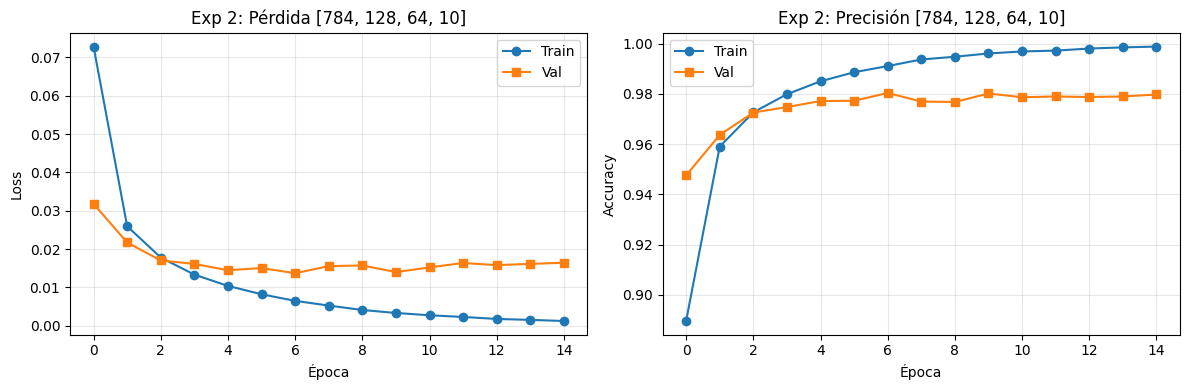


MEJOR EXPERIMENTO: Exp 2
Train Accuracy: 0.9989
Val Accuracy:   0.9798
Train Loss:     0.0013
Val Loss:       0.0165


In [59]:
# Graficar el mejor experimento (Exp 2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Pérdida
ax1.plot(history_exp2.history['loss'], label='Train', marker='o')
ax1.plot(history_exp2.history['val_loss'], label='Val', marker='s')
ax1.set_xlabel('Época')
ax1.set_ylabel('Loss')
ax1.set_title('Exp 2: Pérdida [784, 128, 64, 10]')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Precisión
ax2.plot(history_exp2.history['accuracy'], label='Train', marker='o')
ax2.plot(history_exp2.history['val_accuracy'], label='Val', marker='s')
ax2.set_xlabel('Época')
ax2.set_ylabel('Accuracy')
ax2.set_title('Exp 2: Precisión [784, 128, 64, 10]')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar métricas finales
print(f"\n{'='*50}")
print(f"MEJOR EXPERIMENTO: Exp 2")
print(f"{'='*50}")
print(f"Train Accuracy: {history_exp2.history['accuracy'][-1]:.4f}")
print(f"Val Accuracy:   {history_exp2.history['val_accuracy'][-1]:.4f}")
print(f"Train Loss:     {history_exp2.history['loss'][-1]:.4f}")
print(f"Val Loss:       {history_exp2.history['val_loss'][-1]:.4f}")
print(f"{'='*50}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


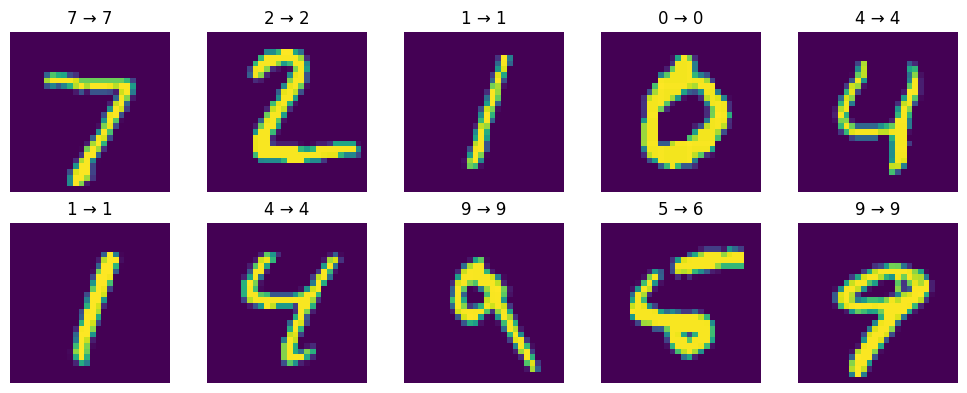

In [61]:
# Predicciones con el mejor modelo (Exp 2)
predictions = model_exp2.predict(x_test[:10])
predicted_labels = np.argmax(predictions, axis=1)

# Visualizar
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_test[i].reshape(28, 28))
    ax.set_title(f"{y_test[i]} → {predicted_labels[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()